In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import codecs, json
from tqdm import tqdm
import numpy as np
from datetime import datetime
import time
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tracemalloc
import torch.nn as nn
import torch.optim as optim
!pip install torchmetrics
from torchmetrics import Accuracy
import sys
sys.path.append('drive/MyDrive/BmiResearch')
from constants import constants

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 25.1 MB/s eta 0:00:00


In [ ]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.optim.lr_scheduler as lr_scheduler

batch size 64

D 5

F1 8

lr 0.001

In [ ]:
chunk_size = 33
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_class = 4
num_epochs = 250
batch_size = 64

class_names_dict = {'RightTO': 0, 'RightHS': 1, 'LeftTO': 2, 'LeftHS': 3}

class_names_dict_1 = {0: 'RightTO',  1: 'RightHS',  2: 'LeftTO',  3: 'LeftHS'}

EEGNet from https://doi.org/10.1088/1741-2552/aace8c.
Shallow and lightweight convolutional neural network proposed for a general decoding of single-trial EEG signals.

In [ ]:
class EEGNet(nn.Module):
    def __init__(self):
        super().__init__()
        fs = 500  # sampling frequency
        channel = 33  # number of electrode
        num_input = 1  # number of channel picture (for EEG signal is always : 1)
        num_class = 4  # number of classes
        signal_length = 75 # 100  # number of sample in each tarial
        F1 = 8  # number of temporal filters
        D = 5  # depth multiplier (number of spatial filters)
        F2 = D * F1  # number of pointwise filters

        kernel_size_1 = (1, round(fs / 2))
        kernel_size_2 = (channel, 1)
        kernel_size_3 = (1, round(fs / 8))
        kernel_size_4 = (1, 1)

        kernel_avgpool_1 = (1, 4)
        kernel_avgpool_2 = (1, 8)
        dropout_rate = 0.2

        ks0 = int(round((kernel_size_1[0] - 1) / 2))
        ks1 = int(round((kernel_size_1[1] - 1) / 2))
        kernel_padding_1 = (ks0, ks1 - 1)
        ks0 = int(round((kernel_size_3[0] - 1) / 2))
        ks1 = int(round((kernel_size_3[1] - 1) / 2))
        kernel_padding_3 = (ks0, ks1)
        # layer 1
        self.conv2d = nn.Conv2d(num_input, F1, kernel_size_1, padding=kernel_padding_1)
        self.Batch_normalization_1 = nn.BatchNorm2d(F1)
        # layer 2
        self.Depthwise_conv2D = nn.Conv2d(F1, D * F1, kernel_size_2, groups=F1)
        self.Batch_normalization_2 = nn.BatchNorm2d(D * F1)
        self.Elu = nn.ELU()
        self.Average_pooling2D_1 = nn.AvgPool2d(kernel_avgpool_1)
        self.Dropout = nn.Dropout2d(dropout_rate)
        # layer 3
        self.Separable_conv2D_depth = nn.Conv2d(D * F1, D * F1, kernel_size_3,
                                                padding=kernel_padding_3, groups=D * F1)
        self.Separable_conv2D_point = nn.Conv2d(D * F1, F2, kernel_size_4)
        self.Batch_normalization_3 = nn.BatchNorm2d(F2)
        self.Average_pooling2D_2 = nn.AvgPool2d(kernel_avgpool_2)
        # layer 4
        self.Flatten = nn.Flatten()
        self.Dense = nn.Linear(F2 * 2, num_class)  # round(signal_length/channel)
        self.Softmax = nn.Softmax(dim=1)

    def forward(self, x):
        #         print("forward x", x.shape)
        # layer 1
        y = self.Batch_normalization_1(self.conv2d(x))  # .relu()
        #         print("layer 1 y", y.shape)
        # layer 2
        y = self.Batch_normalization_2(self.Depthwise_conv2D(y))
        #         print("layer 2 | Batch_normalization_2|  y", y.shape)
        y = self.Elu(y)
        #         print("layer 2 | Elu|  y", y.shape)
        y = self.Dropout(self.Average_pooling2D_1(y))
        #         print("layer 2 | Dropout|  y", y.shape)
        # layer 3
        y = self.Separable_conv2D_depth(y)
        #         print("layer 3 | Separable_conv2D_depth|  y", y.shape)
        y = self.Batch_normalization_3(self.Separable_conv2D_point(y))
        #         print("layer 3 | Batch_normalization_3|  y", y.shape)
        y = self.Elu(y)
        #         print("layer 3 | Elu|  y", y.shape)
        y = self.Dropout(self.Average_pooling2D_2(y))
        #         print("layer 3 | Dropout|  y", y.shape)
        # layer 4
        y = self.Flatten(y)
        #         print("layer 4 | Flatten | y ,", y.shape)
        y = self.Dense(y)  # mat1 and mat2 shapes cannot be multiplied (256x48 and 96x4)
        y = self.Softmax(y)

        return y


def train_one_epoch(model, data_loader, loss_fn, optimizer):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes=num_class).to(device)

    for i, (inputs, targets) in enumerate(data_loader):
        #         print("inputs shape", inputs.shape)
        inputs = inputs.to(device)
        #         print("targets shape", targets.shape)
        targets = targets.to(device)

        outputs = model(inputs)
        #         print("outputs shape", outputs.shape)
        loss = loss_fn(outputs, targets)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        optimizer.zero_grad()

        loss_train.update(loss.item())
        acc_train(outputs, targets.int())

    return model, loss_train.avg, acc_train.compute().item()

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def calculate_weighted_metrics(y_test, y_pred):
    """'weighted':
    Calculate metrics for each label, and find their average weighted by support
    (the number of true instances for each label). This alters ‘macro’ to account for
    label imbalance; it can result in an F-score that is not between
    precision and recall."""
    ACC = accuracy_score(y_test, y_pred)
    PPV = precision_score(y_test, y_pred, average='weighted')
    TPR = recall_score(y_test, y_pred, average='weighted')
    F1 = f1_score(y_test, y_pred, average='weighted')
    return ACC, PPV, TPR, F1


def calculate_weighted_metrics_per_class(y_test, y_pred):
    ACC = accuracy_score(y_test, y_pred)
    PPV = precision_score(y_test, y_pred, average=None)
    TPR = recall_score(y_test, y_pred, average=None)
    F1 = f1_score(y_test, y_pred, average=None)
    PPV = [round(el, 3) for el in PPV]
    TPR = [round(el, 3) for el in TPR]
    F1 = [round(el, 3) for el in F1]
    return ACC, PPV, TPR, F1

def apply_standard_scaling(data_chanks_list_train, one_scaler):
    print('[apply_standard_scaling]')
    print("data_chanks_list_train shape = ", data_chanks_list_train[0].shape)
    final_train_set = []
    for chank_df in tqdm(data_chanks_list_train):
        final_train_set.append(one_scaler.transform(chank_df.T).T)
    return np.array(final_train_set)

def test_one_epoch_cnn(model, test_loader, loss_fn, num_classes):
  model.eval()  # Set the model to evaluation mode
  loss_test = AverageMeter()  # To track the average loss during testing
  acc_test = Accuracy(task="multiclass", num_classes=num_classes).to(device)  # Accuracy metric

  with torch.no_grad():  # No need to track gradients during evaluation
      for i, (inputs, targets) in enumerate(test_loader):
          inputs = inputs.to(device)
          targets = targets.to(device)

          outputs = model(inputs)
          loss = loss_fn(outputs, targets)

          loss_test.update(loss.item())  # Update the running test loss
          acc_test(outputs, targets.int())  # Update the running accuracy

  return loss_test.avg, acc_test.compute().item()


In [ ]:
for sp in constants.SIGNAL_PROCESSING: # ['SLF', 'ASR', 'NOSP']
  for fe in constants.FEATURE_EXTRACTION: # ['ICA', 'CSP', 'NOFE']
    output_path = f'{constants.MODELS}/cnn_es_new_window/{sp}_{fe}'
    print('output_path: ', output_path)
    if (sp == 'NOSP') & (fe == 'NOFE'):
      dataset_path = constants.BASE_DATASET_PATH
    elif (sp != 'NOSP') & (fe == 'NOFE'):
      dataset_path = f'{constants.PREPROCESSED_DATASET_PATH}/{sp}'
    else:
      dataset_path = f'{constants.PREPROCESSED_DATASET_PATH}/{sp}_{fe}'
    print('dataset_path: ', dataset_path)
    for subject in sorted(os.listdir(dataset_path)):
      print(subject)
      experiment_settings = dict()
      experiment_settings['general_params'] = {'low_filter':constants.low_filter,
                                              'high_filter':constants.high_filter,
                                              'frequency':constants.freq,
                                              'minutes_for_test':constants.minutes_for_test,
                                              'window_size':constants.window_size,
                                              'overlap':constants.overlap,
                                              'EEG_CHANNELS':constants.EEG_CHANNELS}
      experiment_settings['subject'] = subject
      experiment_settings['signal_processing'] = sp
      experiment_settings['feature_extraction'] = fe
      experiment_settings['classification'] = 'CNN'
      experiment_settings['DateTime'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
      experiment_settings['dataset_path'] = dataset_path
      output_path_subject = (f'{output_path}/{subject}')
      experiment_settings['OUTPUT_PATH'] = output_path_subject
      os.makedirs(output_path_subject)

      # fit
      fit_df = codecs.open(f'{dataset_path}/{subject}/X_fit.json', 'r', encoding='utf-8').read()
      fit_df = json.loads(fit_df)
      fit_df = np.array(fit_df)

      one_scaler = StandardScaler()
      one_scaler.fit(fit_df)

      # train
      chanks_train = codecs.open(f'{dataset_path}/{subject}/X_train_chunks.json', 'r', encoding='utf-8').read()
      chanks_train = json.loads(chanks_train)
      chanks_train = np.array(chanks_train)

      # test
      chanks_test = codecs.open(f'{dataset_path}/{subject}/X_test_chunks.json', 'r', encoding='utf-8').read()
      chanks_test = json.loads(chanks_test)
      chanks_test = np.array(chanks_test)

      # y train
      final_y_train_list = codecs.open(f'{constants.BASE_DATASET_PATH}/{subject}/y_train_chunks.json', 'r', encoding='utf-8').read()
      final_y_train_list = json.loads(final_y_train_list)
      final_y_train_list = np.array(final_y_train_list)

      # y test
      final_y_test_list = codecs.open(f'{constants.BASE_DATASET_PATH}/{subject}/y_test_chunks.json', 'r', encoding='utf-8').read()
      final_y_test_list = json.loads(final_y_test_list)
      final_y_test_list = np.array(final_y_test_list)

      cnn_train_set = apply_standard_scaling(chanks_train, one_scaler)

      starttime = time.perf_counter()
      cnn_test_set = apply_standard_scaling(chanks_test, one_scaler)
      duration_standard_scaling_s = (time.perf_counter() - starttime)
      scale_1ch_s = round(duration_standard_scaling_s / chanks_test.shape[0], 10)
      experiment_settings['scale_1ch_s'] = scale_1ch_s

      chanks_train = apply_standard_scaling(chanks_train, one_scaler)
      chanks_test = apply_standard_scaling(chanks_test, one_scaler)

      if chanks_train.shape[-1] == chunk_size:
          chanks_train = np.rollaxis(chanks_train, 1, 2)
          chanks_test = np.rollaxis(chanks_test, 1, 2)

      chanks_train = chanks_train.reshape((chanks_train.shape[0], 1, chunk_size, 100))
      cnn_test_set = chanks_test.reshape((chanks_test.shape[0], 1, chunk_size, 100))

      cnn_train_set, cnn_val_set, y_train, y_val = train_test_split(chanks_train, final_y_train_list,
                                                                                        test_size=0.1,
                                                                                        random_state=42)
      dataset = TensorDataset(torch.from_numpy(cnn_train_set).float(),
                              torch.from_numpy(y_train))
      data_loader = DataLoader(dataset,
                                batch_size=batch_size,
                                shuffle=True)

      dataset_val = TensorDataset(torch.from_numpy(cnn_val_set).float(), torch.from_numpy(y_val))
      val_loader = DataLoader(dataset_val, batch_size, shuffle=True)


      model = EEGNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.NAdam(model.parameters(), lr=0.001)
      scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
      loss_train_hist = []
      loss_test_hist = []
      acc_train_hist = []
      acc_test_hist = []
      PATH_models = []
      epoch_num = 0
      best_score = None
      early_stop = False
      counter = 0
      patience = 20

      # Measure time
      starttime = time.perf_counter()
      tracemalloc.start()
      for epoch in range(num_epochs):
        model, loss_train, acc_train = train_one_epoch(model, data_loader, loss_fn, optimizer)
        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        loss_train_hist.append(loss_train)
        acc_train_hist.append(acc_train)
        loss_test, acc_test = test_one_epoch_cnn(model, val_loader, loss_fn, num_classes=4)
        loss_test_hist.append(loss_test)
        acc_test_hist.append(acc_test)

        current, peak = tracemalloc.get_traced_memory()
        duration = round((time.perf_counter() - starttime) / 60, 3)

        print("lr %.4f -> %.4f" % (before_lr, after_lr) + f'epoch {epoch}: Loss= {loss_train:.4}, Accuracy= {int(acc_train * 100)}%')
        print(f"-----current memory usage, MB [{current / (1024 * 1024):0.2f}]~peak memory usage, MB [{peak / (1024 * 1024):0.2f}]~time [{duration}] minutes \n")
        print(f'epoch {epoch}: Train Loss= {loss_train:.4}, Train Accuracy= {int(acc_train * 100)}% | Val Loss: {loss_test:.4}, Val Accuracy: {acc_test:.4}')
        epoch_num = epoch
        print()
        score = -loss_test

        if best_score is None:
          best_score = score
          PATH = f"{output_path_subject}/model_cnn_{sp}_{fe}_{epoch_num}.pt"
          torch.save(model, PATH)
          PATH_models.append(PATH)
        elif score < best_score: # + self.delta:
          counter += 1
          print(f'EarlyStopping counter: {counter} out of {patience}')
          if counter >= patience:
              early_stop = True
        else:
          best_score = score
          counter = 0
          PATH = f"{output_path_subject}/model_cnn_{sp}_{fe}_{epoch_num}.pt"
          torch.save(model, PATH)
          PATH_models.append(PATH)

        if early_stop:
          print("Early stopping")
          break

      current, peak_train_MB = tracemalloc.get_traced_memory()
      duration_train_min = round((time.perf_counter() - starttime) / 60, 3)
      print(
          f"Final current memory usage, MB [{current / (1024 * 1024):0.2f}]~peak memory usage, MB [{peak_train_MB / (1024 * 1024):0.2f}]~time [{duration_train_min}] minutes, ")
      tracemalloc.reset_peak()
      tracemalloc.clear_traces()
      tracemalloc.stop()

      train_dict = {'num_epochs': epoch_num+1, 'loss_train_hist': loss_train_hist,
                    'acc_train_hist': acc_train_hist, 'loss_test_hist':loss_test_hist, 'acc_test_hist':acc_test_hist}
      experiment_settings['train_dict'] = train_dict

      plt.plot(range(epoch_num+1), loss_train_hist, 'b-', label='Train loss')
      plt.plot(range(epoch_num+1), acc_train_hist, 'r-', label='Train Acc')
      plt.plot(range(epoch_num+1), loss_test_hist, 'g-', label='Validation loss')
      plt.plot(range(epoch_num+1), acc_test_hist, 'm-', label='Validation Acc')
      plt.xlabel('Epoch')
      # plt.ylabel('Acc')
      plt.grid(True)
      plt.legend()
      plt.show()

      # inference
      starttime = time.perf_counter()
      tracemalloc.start()

      model.eval()
      cnn_test_set_tensor = torch.from_numpy(cnn_test_set).float().to(device)

      with torch.no_grad():  # Disable gradient calculation for inference
        predictions = model(cnn_test_set_tensor)

      # predictions = model(torch.from_numpy(cnn_test_set).float())
      predictions = np.array([np.argmax(el) for el in predictions.cpu().detach().numpy()])

      current, peak_predict = tracemalloc.get_traced_memory()
      sec_predict = round((time.perf_counter() - starttime), 3)
      tracemalloc.reset_peak()
      tracemalloc.clear_traces()
      tracemalloc.stop()

      labels = unique_labels(final_y_test_list, predictions)
      labels = [class_names_dict_1[el] for el in labels] # name
      ACC_w, PPV_w, TPR_w, F1_w = calculate_weighted_metrics(final_y_test_list, predictions)
      ACC, PPV, TPR, F1 = calculate_weighted_metrics_per_class(final_y_test_list, predictions)

      PATH = f"{output_path_subject}/model_cnn_{sp}_{fe}.pt"
      torch.save(model, PATH)

      print('peak_predict_MB', round(peak_predict / (1024 * 1024), 2))
      print('sec_predict', sec_predict)

      proc_1ch_s = round(sec_predict / chanks_test.shape[0], 5)
      experiment_settings['pred_1_ch_s'] = proc_1ch_s
      experiment_settings['len_test'] = chanks_test.shape[0]

      experiment_settings['y_test'] = list(final_y_test_list[:])
      experiment_settings['prediction'] = list(predictions[:])
      experiment_settings['labels'] = labels
      cm = confusion_matrix(final_y_test_list, predictions, normalize='true')
      experiment_settings['confusion_matrix'] = experiment_settings['confusion_matrix'] = cm.tolist()
      print(cm)
      print("ACC_w, PPV_w, TPR_w, F1_w = ", ACC_w, PPV_w, TPR_w, F1_w)
      print("ACC, PPV, TPR, F1 = ", ACC, PPV, TPR, F1)

      experiment_settings['peak_predict_MB'] = round(peak_predict / (1024 * 1024), 2)
      experiment_settings['sec_predict'] = sec_predict
      experiment_settings['accuracy_score'] = round(ACC_w, 3)
      experiment_settings['precision_score'] = round(PPV_w, 3)
      experiment_settings['recall_score'] = round(TPR_w, 3)
      experiment_settings['f1_score'] = round(F1_w, 3)
      print("round(F1_w, 3) = ", round(F1_w, 3))

      for i, val in enumerate(labels):
          experiment_settings[f'{val}_precision_score'] = f'{round(PPV[i], 3)}'
          experiment_settings[f'{val}_recall_score'] = f'{round(TPR[i], 3)}'
          experiment_settings[f'{val}_f1_score'] = f'{round(F1[i], 3)}'

      json.dump(experiment_settings, codecs.open(f'{output_path_subject}/experiment_results.json', 'w', encoding='utf-8'),
      separators=(',', ':'),
      sort_keys=True,
      indent=4, default=str)


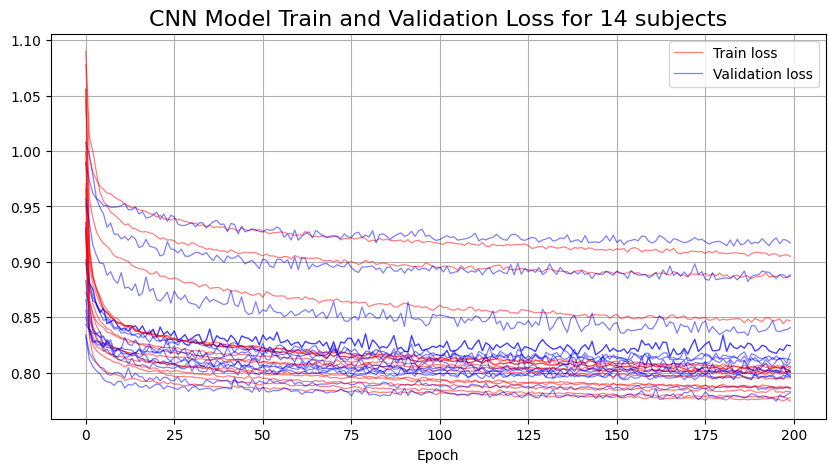

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
output_path = 'drive/MyDrive/BmiResearch/models/cnn200/NOSP_NOFE'
for subject in sorted(os.listdir(output_path)):

  output_path_subject = f'{output_path}/{subject}'
  f = codecs.open(f'{output_path_subject}/experiment_results.json', 'r', encoding='utf-8').read()
  f = json.loads(f)
  if subject == 'sub-001':
    plt.plot(range(200), f['train_dict']['loss_train_hist'], 'r-', label='Train loss', linewidth=0.9, alpha=0.5)
    plt.plot(range(200), f['train_dict']['loss_test_hist'], 'b-', label='Validation loss', linewidth=0.9, alpha=0.5)

  plt.plot(range(200), f['train_dict']['loss_train_hist'], 'r-', linewidth=0.9, alpha=0.5)
  plt.plot(range(200), f['train_dict']['loss_test_hist'], 'b-', linewidth=0.9, alpha=0.5)

plt.xlabel('Epoch')
# plt.ylabel('Acc')
plt.grid(True)
plt.legend()
plt.title(label="CNN Model Train and Validation Loss for 14 subjects", fontsize = 16)
plt.show()

In [ ]:
PATH = f"{exp_folder}model_cnn_{algo}_{feature_extraction}.pt"
model = torch.load(PATH)
model.eval()
outputs = model(torch.from_numpy(final_test_set_np).float())
